# Simple Linear Dynamical System Demo

Linear Dynamical Systems (LDS) are used to model data that evolve in principled ways. They are widely used in control systems, signal processing, neuroscience, and other fields. Our focus in on learning and inference for LDS, and a good reference for this is Chapter 13.3 of [Pattern Recognition and Machine Learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) by Christopher Bishop.


For LDS with Poisson observations, especially as they are used in neuroscience, [Estimating State and parameters in state space models of spike trains](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/FAB8634C2790F3461E3E86BB632EAE6F/9781139941433c6_p137-159_CBO.pdf/estimating_state_and_parameters_in_state_space_models_of_spike_trains.pdf), by J.H Macke _et al_ is a good reference.

## 1. Setup
The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

**Note**: We recently added Seaborn to the list of dependencies. If you have an older installation of SSM, you may need to manually install Seaborn using `pip install seaborn` or `conda install seaborn`.


In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.util import random_rotation
from ssm.plots import plot_dynamics_2d

# Specify whether or not to save figures
save_figures = False

## 2. Create an LDS Object

A Linear Dynamical System consists of a continuous state variable, $x \in \mathbb{R}^D$, which evolves according to linear dynamics.
At time-step $t$, we observe an emission (sometimes called an observation) $y_t \in \mathbb{R}^N$. Similarly, we use $x_t$ to denote the state at time $t$.

The state dynamics obey the following relation (Bishop 2006):

$$
\begin{align}
x_t &= A x_{t-1} + V u_{t} + b + w_t \\
\end{align}
$$

The vector $b$ is an offset vector, which can drive the dynamics in a particular direction. 
The terms $w$ and $v$ are noise terms, which perturb the states and observations. 
Most commonly these are modeled as zero-mean multivariate Gaussians,
but one nice feature of SSM is that it supports many distributions for these noise terms.

We support the following dynamics models, which can be specified by passing an argument to the constructor the LDS class, e.g `dynamics="gaussian"`:

1. **`none`**: Model has no dynamics. At each time-step, the state is drawn independently from a Gaussian. This is the equivalent of filling the dynamics matrix $A$ with zeros.
1. **`gaussian`**: Model has linear-gaussian dynamics. $w \sim \mathcal{N}(0, \Sigma_w )$.
1. **`diagonal_gaussian`**: This is a special case of the Gaussian dynamics model where the noise term has diagonal covariance.
1. **`studentst`**: $w \sim t(0, \Sigma_w, \nu_w)$. 
1. **`diagonal_studentst`**: Constrains covariance matrix to be diagonal.

To specify an LDS, we also need to specify how the emissions $y_t$ are generated (the emissions are what we observe). 
The most common emission model is the simple linear-Gaussian emission model:
$$
y_t = Cx_t + d + F u_t + v_t
$$
In this case, $C$ is called the measurement matrix, $d$ is an offset or bias term, and $F$ is called the feedthrough matrix or passthrough matrix (it passes the input directly to the emission).
$v_t \sim \mathcal{N}(0, \Sigma_v)$ is a noise term, which in the simplest case is Gaussian, but can also be modeled to come from other distributions.
We support the following emission models.

1. **`gaussian`**: The most common emission model. $y_t \sim \mathcal{N}(C x_t + d + F u_t, \Sigma_v)$
1. **`studentst`**: Same as above, but uses the Students-T distribution instead of the normal distribution.
1. **`poisson`**: Useful for modeling count or event data. Under this model, the observations are nonnegative integers drawn from a poisson distribution (Macke 2011).
The latent state controls the rate parameter, in a non-linear fashion as follows. Let $y_{i,t}$ be the $i$-th dimension of our observation at time $t$.
We'll also make use of an excitation vector $g_t = C x_t + d + F u_t$, and additionally a mean function $\eta(\bullet)$.
The observations are drawn from a poisson distribution at rates specified by the excitation vector:
$$P( y_{i,t} \mid g_{i,t}) = \frac{1}{y_{i,t}!} \eta(g_{i,t})^{y_{i,t}}\exp{(-\eta(g_{i,t}))}.$$ By default, the mean function is set to $\exp(\bullet)$.

1. **`bernoulli`**:
As in the Poisson case, we have an excitation vector $g_t = C x_t + d + F u_t$, and a mean function $\eta(\bullet)$. In this case, though, the mean function is always the logistic function, becuase its outputs need to be between zero and one. The observations are drawn from a bernoulli distribution where $y_{i,t}$ is 1 with probability $\eta(g_{i,t})$.

For all of the above we support orthogonal variants, in which the measurement matrix $C$ is constrained to be orthogonal.

_Note: SSM supports many other emission models. We are in the process of creating full-standalone documentation to describe them. For now, the best way to learn about SSM's other functionality is look at the source code. The emission models are described in emissions.py._

The below line creates an instance of the SSM's `LDS` class:  
`true_lds = ssm.LDS(obs_dim, state_dim, dynamics="gaussian", emissions="gaussian")`

Following that, we modify the dynamics matrix (the matrix $A$ in the above equations) so that our system will have some interesting behavior.

The lines most relevant for a user of SSM are these:  
`true_lds.dynamics.A = A  
true_lds.dynamics.b = b`  
  
The first line sets the dynamics matrix $A$ to be the one which we create. The second line sets the offset vector $b$.

In [2]:
# Set the parameters of the LDS
time_bins = 200   # number of time bins
state_dim = 2     # number of latent dimensions
obs_dim = 10      # number of observed dimensions

In [3]:
# Make an LDS with somewhat interesting dynamics parameters
true_lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian_orthog")

A0 = .99 * random_rotation(state_dim, theta=np.pi/20)
S = np.arange(1, state_dim+1)
R = np.linalg.svd(npr.randn(state_dim, state_dim))[0] * S
A = R.dot(A0).dot(np.linalg.inv(R))
b = npr.randn(state_dim)

# Set the dynamics matrix (A) and the 
true_lds.dynamics.A = A
true_lds.dynamics.b = b

## 3. Sample from the LDS and plot
Since our state variable $x$ is two-dimensional, we can plot its path over time in the 2D plane. Below, we plot the trajectory of the state, along with a vector field showing the dynamics of the system. The small blue arrows show the direction that the dynamics of the system will "push" the state at each point.  

Though it's a bit beyond the scope of this notebook, a lot can be said about how the matrix $A$ determins the dynamics of the system. For example, if the spectral radius of $A$ is larger than 1, the system will be unstable, and the state will blow up as time goes to infinity (the spectral radius is the largest singular value). 
We've been hand-wavy in defining stability and instability.
In our case, we have explicitly constructed a stable system, and so we see that the dynamics tend towards a fixed point. 

  
We see that the trajectory (shown in black) follows the blue arrows quite closely, spiraling towards the center. Why doesn't the trajectory follow the arrows exactly? This is because we have noise on the dynamics equation (the $w_t$s in the equations above).

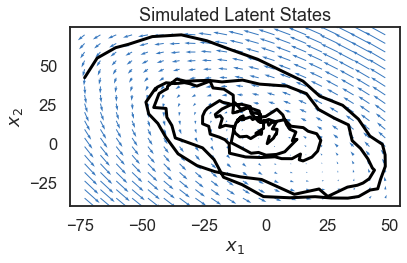

In [4]:
# Sample from the LDS object.
states, emissions = true_lds.sample(time_bins)

# Plot the dynamics vector field
q = plot_dynamics_2d(A, 
                     bias_vector=b,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color=colors[0])

plt.plot(states[:,0], states[:,1], '-k', lw=3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_1.pdf")

### Exercise 3.1: Modify trajectory
See if you can modify the LDS object created in Section 2 so that the system will be unstable. In other words, you want to set the matrix $A$ so that the largest singular value is greater than 1.  

One way of doing this is by starting with the matrix $A$ we used previously, and taking the SVD of that matrix. After taking the SVD, you can modify the largest singular value, and then re-form the dynamics matrix.
After sampling from the system and plotting, do you notice anythign different?

### Exercise 3.2: Advancing $t$ timesteps.
Say the LDS starts at state $x_0$ at time zero. Can you derive an expression for the mode of $p(x_t \mid x_0)$, where $t$ is some number of timesteps in the future?
In other words, what is $ \mathbb{E} \left[x_t \mid x_0 \right]$ ?

## 4. Visualize States and Observations
In the above section, we were able to plot a trajectory for the latent state over time. Since our emissions are 10-dimensional, we can't show a trajectory for them in a 10-d plane (matplotlib doesn't support that yet). Instead, we'll plot each emission coordinate $y_i$ as a function over time. We do the same for the simulated latent states.

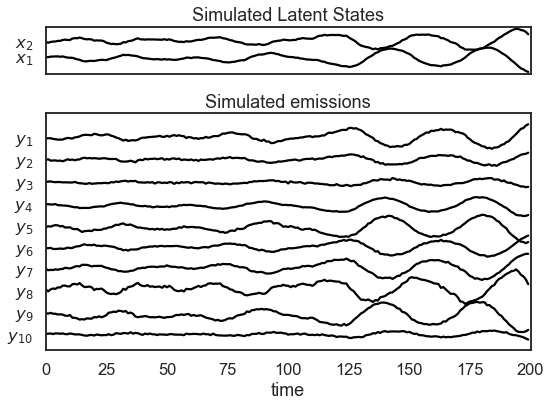

In [5]:
plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, obs_dim/state_dim))

# Plot the continuous latent states
lim = abs(states).max()
plt.subplot(gs[0])
for d in range(state_dim):
    plt.plot(states[:, d] + lim * d, '-k')
plt.yticks(np.arange(state_dim) * lim, ["$x_{}$".format(d+1) for d in range(state_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Simulated Latent States")

lim = abs(emissions).max()
plt.subplot(gs[1])
for n in range(obs_dim):
    plt.plot(emissions[:, n] - lim * n, '-k')
plt.yticks(-np.arange(obs_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(obs_dim)])
plt.xlabel("time")
plt.xlim(0, time_bins)

plt.title("Simulated emissions")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_2.pdf")

## 5. Fit an LDS to Data
Simulating a Linear-Gaussian LDS is all fine, but you're probably interested in fitting an LDS to your own datasets. This is useful, for instance, if you believe that your data are well described by linear dynamical system, and you're interested in examining the dynamics of that system.   
  
In the below cells, we'll treat the variable `emissions` which we generated above as data which comes from an unknown LDS.  
The line `data = emissions` is just to emphasize that our new LDS will be fit from data.  
  
1. First, we make a new LDS object:    
`lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")`  

2. Then we fit the LDS:  
`
elbos, q = lds.fit(data, method="laplace_em", num_iters=10)  
`

3. Next, we get the posterior of the latent states with:  
`state_means = q.mean_continuous_states[0]   
`

4. Finally smooth the observations using our dynamics model:  
`smoothed_obs = lds.smooth(state_means, data)`    


**`LDS.fit`** returns a tuple of `posterior, elbos`. `posterior` is an object representing the posterior of the data given the observations, $p(x \mid y)$.
By default, SSM parameterizes the posterior as a Gaussian with a block-tridiagional precision matrix.
Of most use will probably be `posterior.mean_continuous_states[0]` which returns $\mathbb{E}q(x \mid y)$.
This is our best estimate of the state trajectory given our observations.
By default, calling `LDS.fit` will use the Laplace-EM algorithm, which is a variational inference method. In the case of Gaussian dynamics and Gaussian dynamics, Laplace-EM reduces to the normal EM update rules.
Other fitting methods, like `"svi"` (stochastic variational inference) are also supported, but don't tend to work as well in practice.
We'd recommend sticking to the default fitting methods, at least for now.

**`elbos`** stands for "evidence lower bound" and it is a lower bound on the log-likelihood of the data. It is used to monitor convergence of the EM algorithm


**Note 1**: You'll notice when you call `fit` that you actually see two progress bars, one labeled "LP" and one labeled "ELBO". This is because internally, the fitting is done in two steps. In order to get a good initialization of the paramters, we first initialize using an autoregressive HMM.
Then, we obtain the final parameters using the Laplace-EM algorithm. The first progress bar is showing progress for the initialization (fitting an ar-HMM). 


**Note 2**: We realize some of the APIs are quite weird. For example, `mean_continuous_states[0]` is a bit strange. This is because the APIs are currently shared between vanilla LDS and switching LDS. We plan on fixing this soon, and will update the notebook.

In [6]:
data = emissions

print("Fitting LDS with Laplace-EM using structured variational posterior")
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
elbos, q = lds.fit(data, method="laplace_em", num_iters=10)

# Get the posterior mean of the continuous states
state_means = q.mean_continuous_states[0]

# Smooth the data under the variational posterior
smoothed_obs = lds.smooth(state_means, data)

Fitting LDS with Laplace-EM using structured variational posterior
Initializing with an ARHMM using 25 steps of EM.


Below, we plot the ELBOs which we got from the `fit` function to check that our fitting procedure converged.

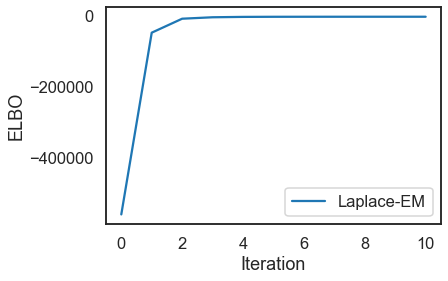

In [7]:
# Plot the ELBOs
plt.plot(elbos, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

## 6. Visualize Model Fit
Below, we show the true and estimated states over time. Although there is an offset between the true state and our estimate, we see that the dynamics of the system seem to match pretty well: our estimate follows a similar trajectory as the true state.  

  
  
We also use our model to "smooth" the emissions by removing noise. Once we have learned the dynamics of the system, we see that we can remove some of the jitter from the emissions.

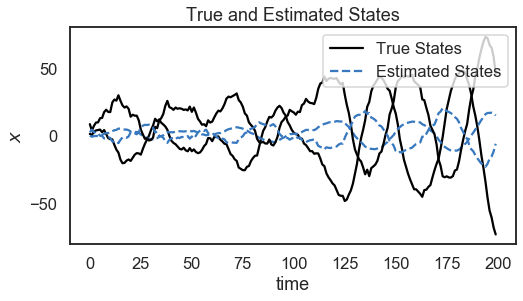

In [8]:
plt.figure(figsize=(8,4))
for d in range(state_dim):
    plt.plot(states[:,d] + 4 * d, '-k', label="True States" if d==0 else None)
    plt.plot(state_means[:,d] + 4 * d, '--', color=colors[0], label="Estimated States" if d==0 else None)
plt.ylabel("$x$")
plt.xlabel("time")
plt.legend(loc='upper right')
plt.title("True and Estimated States")
plt.show()

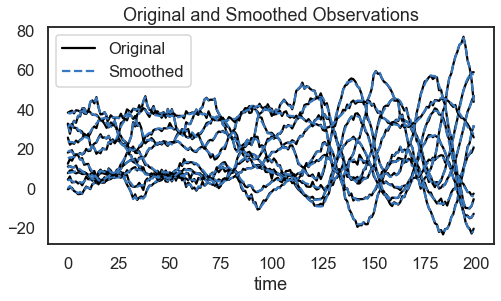

In [9]:
# Plot the smoothed emissions
plt.figure(figsize=(8,4))
for n in range(obs_dim):
    plt.plot(emissions[:, n] + 4 * n, '-k', label="Original" if n == 0 else None)
    plt.plot(smoothed_obs[:, n] + 4 * n, '--', color=colors[0], label="Smoothed" if n == 0 else None)
plt.legend()
plt.xlabel("time")
plt.title("Original and Smoothed Observations")
plt.show()

Below, we visualize the true dynamics, as well as the dynamics of the system we learned. We would hope that the overall features would be the same, though the overall dynamics might be rotated.

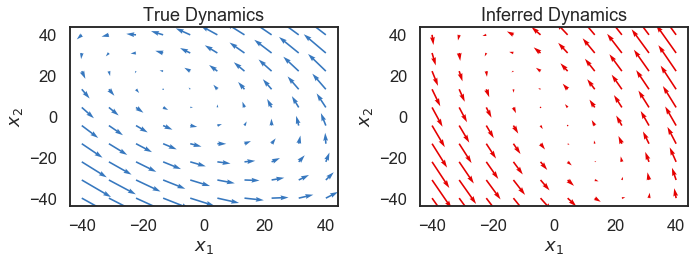

In [10]:
# Extract dynamics matrix from the true model
A_true = true_lds.dynamics.A
b_true = true_lds.dynamics.b

A_est = lds.dynamics.A
b_est = lds.dynamics.b

f, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_dynamics_2d(A_true, b_true, npts=10, axis=ax[0], color=colors[0])
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title("True Dynamics")

plot_dynamics_2d(A_est, b_est, npts=10, axis=ax[1], color=colors[1])
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")
ax[1].set_title("Inferred Dynamics")

plt.tight_layout()

### Exercise 6.1: Mis-specified Dynamics Model
What you expect to happen if you fit an HMM to your data when the true dataset was generated by an LDS? Assume that in both cases, the observation model is Gaussian, so that only the dynamics model is misspecified.  

How would the performance of your model change as you increase the number of discrete states in the HMM?

## 7. Simulate Poisson data from a Poisson LDS with the same dynamics

In the below cells, we create an LDS with poisson observations that shares the dynamics of the LDS above.
The line:  

`plds = ssm.LDS(obs_dim, state_dim, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))   
`

creates an LDS object with Poisson observations.
Specifying `link="softplus"` specifes that the link function will be the softplus function.
The term `link` refers to the link a generalized linear model, which controls how the linear latent variable, in this case the state $x_t$ controls the emission distribution.
When creating a Poisson or Bernoulli LDS, the user specifies the link function, which allows in-turn sets the mean function of the emissions.  

For Poisson LDS, SSM supports two link functions:  
1. `link="softplus"`: The mean function $\eta(x)$ is set to the inverse softplus function.
2. `link="log"`: The mean function  $\eta(x)$ is set to the exponential function.
  

Below, we copy the parameters from our prior LDS to the new object:  
`plds.dynamics.params = copy.deepcopy(true_lds.dynamics.params)
`

We use `copy.deepcopy` to make sure we don't accidentally change the parameters in the other LDS object.
The Poisson emissions are composed of a linear mapping from the continuous states:
$$z_t = C x_t + d + F u$$  
In the below line, we set the bias vector $d$ in the above equation to zeros:  
`
plds.emissions.ds = 0 * np.ones(obs_dim)
`

After sampling from our Poisson LDS, we sample and show the trajectory, as before. We then also visualize our Poisson observations. Since Poisson observations are nonnegative integers, we plot them as a color density.

In [11]:
import copy

plds = ssm.LDS(obs_dim, state_dim, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
plds.dynamics.params = copy.deepcopy(true_lds.dynamics.params)
plds.emissions.ds = 0 * np.ones(obs_dim)
states_plds, obs_plds = plds.sample(time_bins)

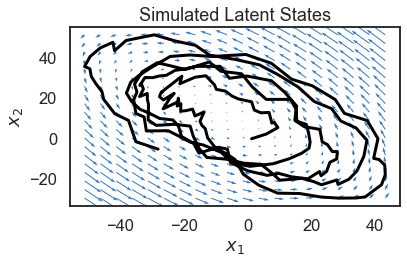

In [12]:
# Plot the dynamics vector field
plot_dynamics_2d(plds.dynamics.A,
                 plds.dynamics.b,
                 mins=states_plds.min(axis=0),
                 maxs=states_plds.max(axis=0),
                 color=colors[0])
plt.plot(states_plds[:,0], states_plds[:,1], '-k', lw=3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_6.pdf")

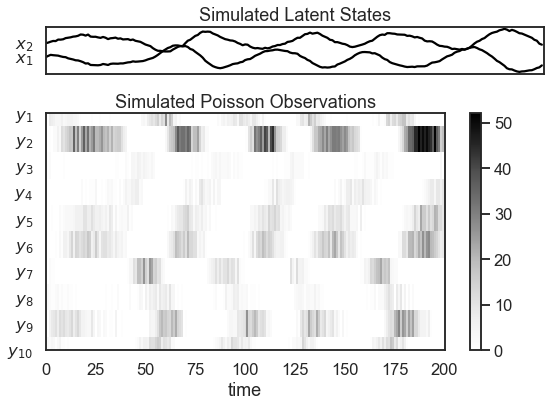

In [13]:
# Plot the dynamics vector field
plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, obs_dim/state_dim))

# Plot the continuous latent states
lim = abs(states_plds).max()
plt.subplot(gs[0])
for d in range(state_dim):
    plt.plot(states_plds[:, d] + lim * d, '-k')
plt.yticks(np.arange(state_dim) * lim, ["$x_{}$".format(d+1) for d in range(state_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Simulated Latent States")

lim = abs(obs_plds).max()
plt.subplot(gs[1])
plt.imshow(obs_plds.T, cmap="Greys", aspect="auto")
plt.yticks(np.arange(obs_dim), ["$y_{{ {} }}$".format(n+1) for n in range(obs_dim)])
plt.xlabel("time")
plt.xlim(0, time_bins)
plt.title("Simulated Poisson Observations")
plt.colorbar()

plt.tight_layout()

if save_figures:
    plt.savefig("lds_7.pdf")

### Exercise 7.1: Mis-specified Observation Model
What you expect to happen if you fit an LDS with Gaussian observations to a system where the true observation model is Poisson?  

You can try this by following the steps in Section 5 using the data we generated in Section 7.